In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
mass = 1000
vi = 0
dt = 0.1
cd = 0.1

In [3]:
def velocity(throttle, current):
    #print(throttle, current)
    F = throttle - cd * current ** 2
    a = F/mass
    vf = current + a * dt # + np.random.normal(0, 0.1)
    return vf

In [4]:
kp = 300
ki = 1.5
kd = 45

In [5]:
def velocity(throttle, current):
    F = throttle - cd * current ** 2
    a = F/mass
    vf = current + a*dt # + np.random.normal(0, 0.1)
    
    return vf

In [6]:
# Variables to store previous values
prev_error = 0
integral = 0

def speed_controller(target_speed, current_speed, dt):
    global prev_error, integral  # Keep values across function calls
    
    # Compute error
    error = target_speed - current_speed
    
    # Proportional term
    p = error
    
    # Integral term (accumulate over time)
    integral += error * dt
    
    # Derivative term (rate of change of error)
    d = (error - prev_error) / dt if dt > 0 else 0 
    
    # Compute PID output
    output = (kp * p) + (ki * integral) + (kd * d)
    
    # Store error for next derivative calculation
    prev_error = error
    
    return output

In [7]:
def collision_avoidance(obstacle_at, current_distance, current_speed, throttle):
    distance_from_obstacle = abs(obstacle_at - current_distance)
    if distance_from_obstacle > 400:
        return throttle
    else:
        # speed = 0 at car <= 25 meters
        # m = current_speed / distance_from_obstacle # linear decay

        # no division by 0
        # m = current_speed / (distance_from_obstacle + 10)

        # quadratic decay (still relatively linear)
        # m = current_speed / (distance_from_obstacle ** 2 + 1)

        # exponential decay 
        # decay_factor = 60
        # m = math.exp(-distance_from_obstacle / decay_factor) * current_speed

        # sigmoid function
        C = 50  # Center point where braking becomes steep
        S = 60   # Slope factor for smooth braking transition

        m = (1 / (1 + math.exp((distance_from_obstacle - C) / S))) * current_speed

        # cubic decay (too aggressive)
        # m = (1 - (distance_from_obstacle / obstacle_at)**3) * current_speed

        # logarithmic decay (too aggressive and instant)
        # scale_factor = 20  # Adjust this to control how smoothly it slows down
        # m = math.log(distance_from_obstacle + 1) / scale_factor * current_speed
        
        return -m * 1000
        

In [8]:
def master_controller(target_speed, current_speed, obstacle_at, current_distance, dt):
    throttle = speed_controller(target_speed, current_speed, dt)
    throttle = collision_avoidance(obstacle_at, current_distance, current_speed, throttle)
    return throttle

In [9]:
target_speed = 80
current_speed = vi

current_distance = 0 
obstacle_at = 4000

result = [] 
for t in np.arange(0, 600, dt):

    # stopping condition
    if current_distance >= obstacle_at:
        break
    
    throttle = master_controller(target_speed, current_speed, obstacle_at, current_distance, dt)
    # print(throttle)
    current_speed = velocity(throttle, current_speed)

    current_distance += current_speed * dt
    # print(current_distance)
    result.append([t, throttle, current_distance, current_speed])

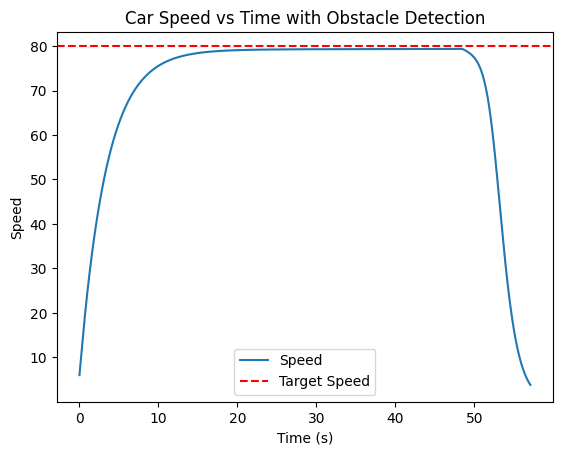

In [10]:
r = np.array(result)
plt.plot(r[:, 0], r[:, 3], label="Speed")
plt.axhline(target_speed, color="red", linestyle="dashed", label="Target Speed")
# plt.axhline(100, color="green", linestyle="dashed", label="Target 100")
# plt.axhline(50, color="yellow", linestyle="dashed", label="Target 50")

plt.xlabel("Time (s)")
plt.ylabel("Speed")
plt.legend()
plt.title("Car Speed vs Time with Obstacle Detection")
plt.show()

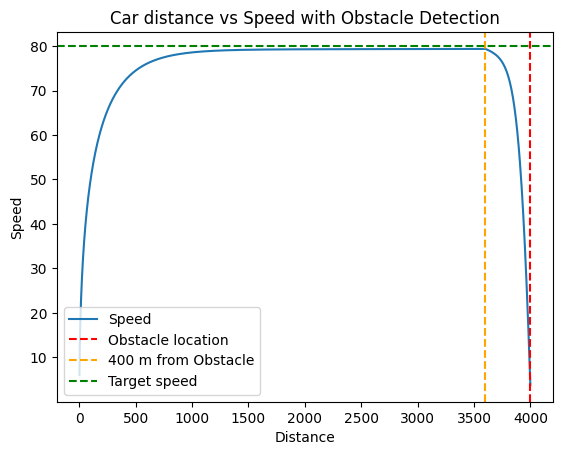

In [11]:
r = np.array(result)
plt.plot(r[:, 2], r[:, 3], label="Speed")
plt.axvline(obstacle_at, color="red", linestyle="dashed", label="Obstacle location")
plt.axvline(obstacle_at-400, color="orange", linestyle="dashed" , label="400 m from Obstacle")
plt.axhline(target_speed, color="green", linestyle="dashed", label="Target speed")
# plt.axhline(80, color="red", linestyle="dashed", label="Target 80")
# plt.axhline(100, color="green", linestyle="dashed", label="Target 100")
# plt.axhline(50, color="yellow", linestyle="dashed", label="Target 50")

plt.xlabel("Distance")
plt.ylabel("Speed")
plt.legend(loc='lower left')
plt.title("Car distance vs Speed with Obstacle Detection")
plt.show()

In [12]:
np.set_printoptions(suppress=True, precision=1, threshold=1000)
r

array([[    0. , 60012. ,     0.6,     6. ],
       [    0.1, 19522.2,     1.4,     8. ],
       [    0.2, 20769.7,     2.4,    10. ],
       ...,
       [   56.9, -3266.9,  3999.3,     4.4],
       [   57. , -3047.2,  3999.7,     4.1],
       [   57.1, -2841.3,  4000.1,     3.8]], shape=(572, 4))

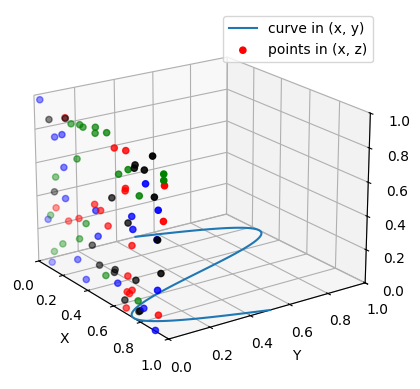

In [13]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(x, y, zs=0, zdir='z', label='curve in (x, y)')

# Plot scatterplot data (20 2D points per colour) on the x and z axes.
colors = ('r', 'g', 'b', 'k')

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.random.sample(20 * len(colors))
y = np.random.sample(20 * len(colors))
c_list = []
for c in colors:
    c_list.extend([c] * 20)
# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x, y) points are plotted on the x and z axes.
ax.scatter(x, y, zs=0, zdir='y', c=c_list, label='points in (x, z)')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

plt.show()